<a href="https://colab.research.google.com/github/modichirag/galmodel/blob/u%2FEiffL%2FCosmicRIM/notebooks/CosmicRIM_TPU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Installing dependencies


In [1]:
!pip install git+https://github.com/modichirag/flowpm.git@u/EiffL/TPU
!git clone https://github.com/modichirag/flowpm.git
!git clone https://github.com/modichirag/galmodel.git -b u/EiffL/CosmicRIM

  Cloning https://github.com/modichirag/flowpm.git (to revision u/EiffL/TPU) to /tmp/pip-req-build-duy_z8d1
  Running command git clone -q https://github.com/modichirag/flowpm.git /tmp/pip-req-build-duy_z8d1
  Running command git checkout -b u/EiffL/TPU --track origin/u/EiffL/TPU
  Switched to a new branch 'u/EiffL/TPU'
  Branch 'u/EiffL/TPU' set up to track remote branch 'u/EiffL/TPU' from 'origin'.
  Created wheel for flowpm: filename=flowpm-0.1-cp36-none-any.whl size=11318 sha256=bc16c711e9e198241e32855941844a95b684f1dece1d3e6c0bb656c7669b8e93
  Stored in directory: /tmp/pip-ephem-wheel-cache-pi6978b_/wheels/7d/45/5d/c6ad7d04527b1275883565247915406a8f7c183ed65572eaf8
Successfully built flowpm
Cloning into 'flowpm'...
remote: Enumerating objects: 239, done.
remote: Counting objects: 100% (239/239), done.
remote: Compressing objects: 100% (169/169), done.
remote: Total 239 (delta 137), reused 153 (delta 62), pack-reused 0
Receiving objects: 100% (239/239), 156.19 KiB | 4.11 MiB/s, don

In [0]:
import sys
sys.path.insert(0,'galmodel/')

In [3]:
# Authenticate on GCP
from google.colab import auth
auth.authenticate_user() # Authenticates the backend and also the TPU using your credentials so that they can access your private GCS buckets

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



In [4]:
import tensorflow as tf
try: # TPU detection
  tpu = tf.contrib.cluster_resolver.TPUClusterResolver() # Picks up a connected TPU on Google's Colab, ML Engine, Kubernetes and Deep Learning VMs accessed through the 'ctpu up' utility
  #tpu = tf.contrib.cluster_resolver.TPUClusterResolver('MY_TPU_NAME') # If auto-detection does not work, you can pass the name of the TPU explicitly (tip: on a VM created with "ctpu up" the TPU has the same name as the VM)
  print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
  master = tpu.get_master()
  USE_TPU = True
except ValueError:
  tpu = None
  print("Running on GPU or CPU")
  USE_TPU = False

Running on TPU  ['10.14.19.202:8470']


In [0]:
BUCKET = 'gs://cosmic_rim' #@param {type:"string"}

## Moving on to the main business

In [6]:
%pylab inline
colormap = np.array(plt.rcParams['axes.prop_cycle'].by_key()['color'])

Populating the interactive namespace from numpy and matplotlib


In [0]:
import tensorflow as tf

import flowpm
from scipy.interpolate import InterpolatedUnivariateSpline as iuspline

klin = np.loadtxt('flowpm/flowpm/data/Planck15_a1p00.txt').T[0]
plin = np.loadtxt('flowpm/flowpm/data/Planck15_a1p00.txt').T[1]

ipklin = iuspline(klin, plin)

### Build data pipeline

In [0]:
# Parameters of the simulations
a0 = 0.1
stages = np.linspace(a0, 1.0, 2, endpoint=True)
boxsize = 100
nc = 32
# Local batch size, the global batch size will be 8x that
batch_size = 2

def sample_sim(dummy):
  """ Draws a batch of realizations of initial cond
  """
  initial_conditions = flowpm.linear_field(nc, boxsize, ipklin, batch_size=batch_size)
  state = flowpm.lpt_init(initial_conditions, a0=a0)
  final_state = flowpm.nbody(state, stages, nc)
  final_field = flowpm.cic_paint(tf.zeros_like(initial_conditions), final_state[0])
  # return features, labels
  return tf.expand_dims(final_field, axis=-1), tf.expand_dims(initial_conditions, axis=-1)

In [0]:
# Create the dataset input function
def input_fn(params):
  dset = tf.data.Dataset.range(100000)
  dset = dset.map(sample_sim)
  dset = dset.apply(tf.data.experimental.unbatch())
  dset = dset.batch(params['batch_size'], drop_remainder=True)
  return dset

## Build estimator

In [0]:
from galmodel.layers.recurrent_inference import ConvRIM3D
from galmodel.layers.convolutional_recurrent import ConvLSTM3DCell

def pm(lin):
  state = flowpm.lpt_init(lin, a0=a0)
  final_state = flowpm.nbody(state, stages, nc)
  final_field = flowpm.cic_paint(tf.zeros_like(lin), final_state[0])
  return final_field

def likelihood_fn(inputs, predictions):
  """ Evaluates the data likelihood function through Fast PM
  """
  final_field = pm(predictions[..., 0])
  likelihood = tf.reduce_mean((final_field - inputs[...,0])**2, 
                              axis=[1, 2, 3])
  return likelihood


def model_fn(features, labels, mode, params):
  """
  Model function for the CosmicRIM.
  """
  
  is_training = mode == tf.estimator.ModeKeys.TRAIN
  
  # Build the RIM
  cell = ConvLSTM3DCell(filters=128, kernel_size=3, padding='SAME')
  output_layer = tf.keras.layers.Conv3D(filters=1, kernel_size=3, padding='SAME')
  
  cosmic_rim = ConvRIM3D(cell,
                       output_layer,
                       likelihood_fn=likelihood_fn,
                       niter=10, 
                       return_sequences=True)

  preds = cosmic_rim(features)
  predictions = {'preds':tf.transpose(preds, [1,0,2,3,4,5]), 
                 'fins':pm(preds[-1][...,0]),
                 'features': features,
                 'labels':labels}
  
  if mode == tf.estimator.ModeKeys.PREDICT:
    return tf.estimator.tpu.TPUEstimatorSpec(mode=mode, 
                                             predictions=predictions)
  
  batch_loss = tf.reduce_mean((preds - labels)**2, axis=[0, 2, 3, 4, 5])

  loss = tf.reduce_mean(batch_loss)
  
  
  train_op = None
   
  learning_rate = tf.train.exponential_decay(0.001,
        tf.train.get_global_step(),
        decay_steps=100000,
        decay_rate=0.96)
  optimizer=tf.train.AdamOptimizer(learning_rate=learning_rate)
  optimizer = tf.tpu.CrossShardOptimizer(optimizer)
  
  # Define optimizer
  if mode == tf.estimator.ModeKeys.TRAIN:
    update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    with tf.control_dependencies(update_ops):
      train_op = optimizer.minimize(loss=loss,
                                     global_step=tf.train.get_global_step())
    
  return tf.estimator.tpu.TPUEstimatorSpec(mode=mode,
                                      loss=loss,
                                      train_op=train_op)

In [11]:
# TPU_REFACTORING: to use all 8 cores, increase the batch size by 8
GLOBAL_BATCH_SIZE = batch_size * 8
print('Effective batch size:', GLOBAL_BATCH_SIZE)
MODEL_DIR = BUCKET+"/rim/test3" 

Effective batch size: 16


In [12]:
config = tf.estimator.tpu.RunConfig(
    master=master,
    model_dir=MODEL_DIR,
    save_checkpoints_steps=500,
    session_config=tf.ConfigProto(
        allow_soft_placement=True, 
        log_device_placement=True),
    tpu_config=tf.estimator.tpu.TPUConfig(100, 8))

estimator = tf.estimator.tpu.TPUEstimator(
    model_fn=model_fn,
    config=config,
    use_tpu=True,
    train_batch_size=GLOBAL_BATCH_SIZE,
    eval_batch_size=GLOBAL_BATCH_SIZE,
    predict_batch_size=GLOBAL_BATCH_SIZE
  )

INFO:tensorflow:Using config: {'_model_dir': 'gs://cosmic_rim/rim/test3', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': 500, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
log_device_placement: true
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': None, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f89cb22d6d8>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': 'grpc://10.14.19.202:8470', '_evaluation_master': 'grpc://10.14.19.202:8470', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1, '_tpu_config': TPUConfig(iterations_per_loop=100, num_shards=8, num_cores_per_replica=None, per_host_input_for_training=2, tpu

In [0]:
estimator.train(input_fn, steps=10000)

INFO:tensorflow:Querying Tensorflow master (grpc://10.14.19.202:8470) for TPU system metadata.
INFO:tensorflow:Found TPU system:
INFO:tensorflow:*** Num TPU Cores: 8
INFO:tensorflow:*** Num TPU Workers: 1
INFO:tensorflow:*** Num TPU Cores Per Worker: 8
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:CPU:0, CPU, -1, 1746218776488241072)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:0, TPU, 17179869184, 15266776311301884947)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:1, TPU, 17179869184, 17884034267203660143)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:2, TPU, 17179869184, 7020095540981684389)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:3, TPU, 17179869184, 15382524165773271312)
INFO:tensorflow:*** Available Device: _Devi

In [0]:
preds = estimator.predict(input_fn=input_fn, yield_single_examples=True)

In [0]:
res = next(preds)

/usr/local/lib/python3.6/dist-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


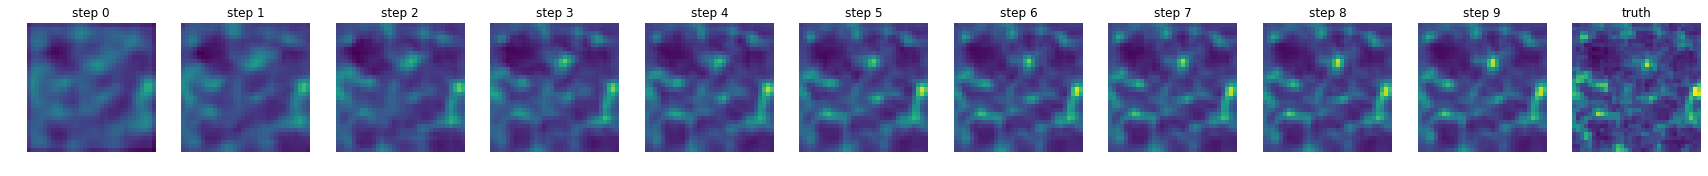

In [45]:
ref = np.squeeze(res['labels']).sum(axis=0)

figure(figsize=(30,7))
for i in range(10):
  subplot(1,11,i+1)
  imshow(np.squeeze(res['preds'][i]).sum(axis=0), vmin=ref.min(), vmax=ref.max())
  axis('off')
  title('step %d'%i)

  subplot(1,11,11)
  imshow(ref, vmin=ref.min(), vmax=ref.max())
  title('truth')
  axis('off')

Text(0.5, 1.0, 'final field')

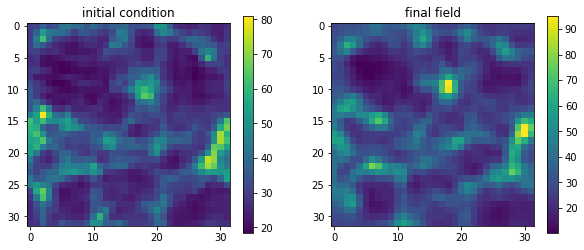

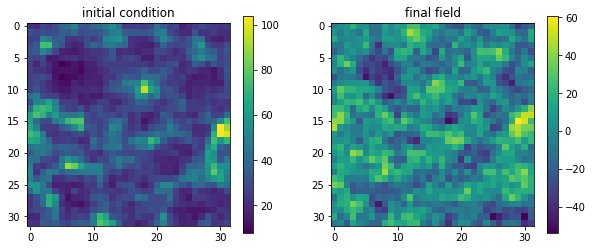

In [41]:
figure(figsize=(10,4))
subplot(121)
imshow(np.squeeze(res['fins']).sum(axis=0))
title('initial condition')

colorbar()
subplot(122)
imshow(np.squeeze(res['preds'][-1]).sum(axis=0))
colorbar()

title('final field')

figure(figsize=(10,4))
subplot(121)
imshow(np.squeeze(res['labels']).sum(axis=0))
colorbar()
title('initial condition')

subplot(122)
imshow(np.squeeze(res['features']).sum(axis=0))
colorbar()
title('final field')